### Define the Problem Statement and perform Exploratory Data Analysis

In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import keras 

In [13]:
# Check if TensorFlow is built with CUDA support
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA support.")
else:
    print("TensorFlow is not built with CUDA support.")

# Check if a GPU is available and visible
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available.")
else:
    print("CUDA is not available.")

TensorFlow is built with CUDA support.
CUDA is not available.


I0000 00:00:1722680717.433821   19705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 15:55:17.433939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

I0000 00:00:1722680871.102832   19705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 15:57:51.102983: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Pre-processing

In [30]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line:
                token, tag = line.split('\t')
                sentence.append((token, tag))
            else:
                if sentence:
                    sentences.append(sentence)
                    sentence = []

    return sentences

In [41]:
file_path = "dataset/wnut 16.txt.conll"
data  = read_conll(file_path)
 
data

[[('@SammieLynnsMom', 'O'),
  ('@tg10781', 'O'),
  ('they', 'O'),
  ('will', 'O'),
  ('be', 'O'),
  ('all', 'O'),
  ('done', 'O'),
  ('by', 'O'),
  ('Sunday', 'O'),
  ('trust', 'O'),
  ('me', 'O'),
  ('*wink*', 'O')],
 [('Made', 'O'),
  ('it', 'O'),
  ('back', 'O'),
  ('home', 'O'),
  ('to', 'O'),
  ('GA', 'B-geo-loc'),
  ('.', 'O'),
  ('It', 'O'),
  ('sucks', 'O'),
  ('not', 'O'),
  ('to', 'O'),
  ('be', 'O'),
  ('at', 'O'),
  ('Disney', 'B-facility'),
  ('world', 'I-facility'),
  (',', 'O'),
  ('but', 'O'),
  ('its', 'O'),
  ('good', 'O'),
  ('to', 'O'),
  ('be', 'O'),
  ('home', 'O'),
  ('.', 'O'),
  ('Time', 'O'),
  ('to', 'O'),
  ('start', 'O'),
  ('planning', 'O'),
  ('the', 'O'),
  ('next', 'O'),
  ('Disney', 'B-facility'),
  ('World', 'I-facility'),
  ('trip', 'O'),
  ('.', 'O')],
 [("'", 'O'),
  ('Breaking', 'B-movie'),
  ('Dawn', 'I-movie'),
  ("'", 'O'),
  ('Returns', 'O'),
  ('to', 'O'),
  ('Vancouver', 'B-geo-loc'),
  ('on', 'O'),
  ('January', 'O'),
  ('11th', 'O'),
  ('h

In [42]:
# Convert to a DataFrame if needed
df = pd.DataFrame([(token, tag) for value in data for token, tag in value], columns=['Token', 'Tag'])
print(df.head())

             Token Tag
0  @SammieLynnsMom   O
1         @tg10781   O
2             they   O
3             will   O
4               be   O


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46462 entries, 0 to 46461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Token   46462 non-null  object
 1   Tag     46462 non-null  object
dtypes: object(2)
memory usage: 726.1+ KB


In [34]:
df.shape

(46462, 2)

In [35]:
print("Number of sentences: ", len(data))

Number of sentences:  2393


In [38]:
print("Number of labels", df["Tag"].nunique())

Number of labels 21


In [39]:
print("Frequency of labels", df["Tag"].value_counts())

Frequency of labels Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64


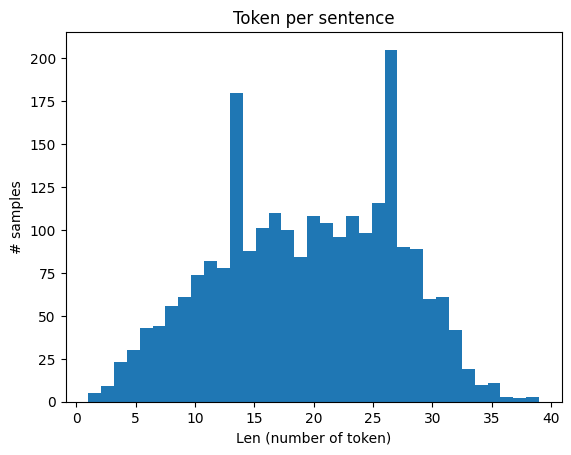

In [66]:
# Plot sentence by lenght
plt.hist([len(s) for s in data], bins=35)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

From the histogram, we can see most of the sentences have around <b> 15 to 30 tokens </b>. Tokens can we referred as words ignoring punctuation marks.

In [ ]:
# 